Проведем разведочный анализ данных по следующим шагам, to do list для себя. Я выбрал датасет - 10 Т-Банк: звонки операторов клиентам, 
так как в начале карьеры работал в технической поддержке интернета и данная тема мне близка.
1. Общие характеристики
Общее количество звонков. +
Количество уникальных операторов и клиентов. +
Период, за который есть данные (min/max call_datetime). +
Распределение по по причине звонка. +
Какие типы звонков наиболее частые/редкие+

3. Анализ длительности звонков
Средняя, медианная, минимальная и максимальная длительность. +
Распределение длительности звонков +

4. Временные закономерности
Количество звонков по дням/неделям/месяцам. +
Активность в течение суток. +

5. Анализ операторов
Топ-10 операторов по количеству звонков. +
Средняя длительность звонков по каждому оператору. +
Соотношение успешных звонков по каждому оператору. +
Операторы с подозрительно высокой долей отказов+

6. Аномалии и подозрительные случаи
Звонки с нулевой длительностью +
Повторяющиеся звонки одному клиенту+

7. Гипотезы
Упешность зависят от типа звонка. Сравнение успешности по типам звонков. +
Чем больше звонков делает оператор, тем меньше результативность. +

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('sale_tasks_dataset.csv')
# для наглядности и простоты восприятия информации выберем только полезные для нас колонки
df = df[['customer_id', 'state_talk_time_sec', 'product_cd', 'functional_cd', 'wo_hit_status_result_desc','wo_hit_status_reason_desc', \
         'finish_dttm','employee_id']]
df

,customer_id,state_talk_time_sec,product_cd,functional_cd,wo_hit_status_result_desc,wo_hit_status_reason_desc,finish_dttm,employee_id
0,422206773,67.0,Debit Cards,Meeting,"Дозвон, Отказ",Перезвонит самостоятельно позднее,2022-04-12 07:00:00,142052.0
1,348648289,151.0,Cash Loan,Upsell,"Дозвон, Отказ",Другое,2023-10-25 20:00:00,7004.0
2,345496995,68.0,MVNO,Afterfilling,"Дозвон, Успешно",Назначена встреча,2023-06-16 07:00:00,80760.0
3,182783192,738.0,Investment,Utilization,"Дозвон, Успешно",Обещал утилизироваться самостоятельно,2022-09-23 12:00:00,158672.0
4,138498254,39.0,Cash Loan,Incoming,"Дозвон, Отказ",Переведен в банк,2023-02-27 16:00:00,14462.0
...,...,...,...,...,...,...,...,...
18686,365712573,101.0,Cash Loan,Upsell,"Дозвон, Отказ",Не устраивает одобренная сумма,2023-05-24 10:00:00,191799.0
18687,305526568,75.0,Credit Cards,Preapprove,"Дозвон, Отказ",Кредитная карта не нужна,2024-04-26 12:00:00,265923.0
18688,77876991,59.0,Cash Loan,Preapprove,"Дозвон, Отказ",Кредит уже не нужен,2024-04-12 16:00:00,215719.0
18689,321508947,NaN,Mortgage Insurance,Afterfilling,"Дозвон, Отказ",Вопросы по оплаченному полису,2022-09-08 09:00:00,97765.0


In [5]:
print('Количество звонков:', df['customer_id'].count(),'\nКоличество уникальных клиентов:', df['customer_id'].nunique(),\
      '\nКоличество уникальных сотрудников:', df['employee_id'].nunique(), \
      '\nПериод данных от:', df['finish_dttm'].min(), 'до', df['finish_dttm'].max())

Количество звонков: 18691 
Количество уникальных клиентов: 17267 
Количество уникальных сотрудников: 726 
Период данных от: 2022-01-01 21:00:00 до 2024-11-05 19:00:00


In [7]:
# Распределение по причине звонка
df_functional = df.groupby('functional_cd', as_index=False).agg(cnt_ring = ('functional_cd', 'count')).sort_values('cnt_ring', ascending=False)
df_functional

,functional_cd,cnt_ring
10,Preapprove,9025
1,Afterfilling,2352
15,Utilization,1717
5,Cold,1537
14,Upsell,1342
9,Meeting,1064
2,Agreement,547
8,Incoming,361
7,Downsell,229
13,Reutilization,228


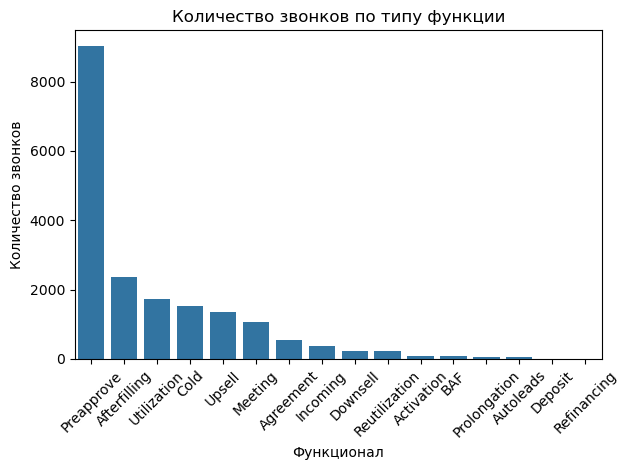

In [9]:
# Cтроим столбчатаю диаграмму распределения кол-ва звонков по типу звонка.
# Наблюдаем явное преобладание звонков 'Preapprove — предодобренные заявки'.
sns.barplot(data=df_functional, x='functional_cd', y='cnt_ring')

plt.title('Количество звонков по типу функции')
plt.xlabel('Функционал')
plt.ylabel('Количество звонков')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# выводим различные статистические показатели длительности звонков в секундах.\
# Видим звонки по 0 секунд, необходимо gроверить записи логов из телефонии, чтобы выяснить точную причину.
# Так же меня смущают сверхдлинные звонки по 2500 сек( по 40 минут). Позже придумаем гипотезу почему так.
# Количество непустых значений 18543, а всего 18691. Необходимо проверить базу на предмет поетри данных
print(df['state_talk_time_sec'].describe())

count    18543.000000
mean        86.350105
std        127.011570
min          0.000000
25%         24.000000
50%         46.000000
75%         99.000000
max       2671.000000
Name: state_talk_time_sec, dtype: float64


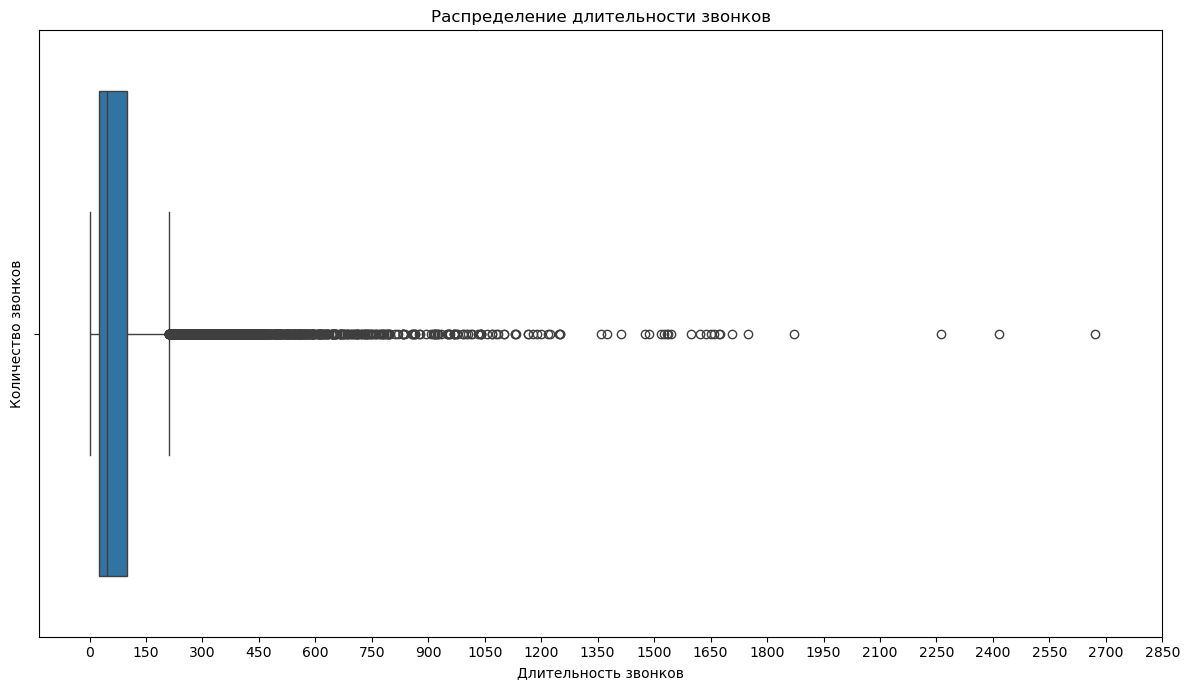

In [17]:
# строим ящик с усами для анализа распределения звонков по длительности и поиска выбросов
plt.figure(figsize=(12,7))

sns.boxplot(data=df, x='state_talk_time_sec')
plt.title('Распределение длительности звонков')
plt.xlabel('Длительность звонков')
plt.ylabel('Количество звонков')
plt.xticks(range(0, 3000, 150))
plt.tight_layout()
plt.show()

Вывод по графику:
1) Медиана ближе к нижнему краю — распределение с длинным "хвостом" вправо (положительная асимметрия)
2) Я щик у нас получился узкий — значения сконцентрированы.
3) Точки за пределами усов = аномально длинные звонки. Их много — стоит изучить природу этих значений.
4) Короткие усы говорят о небольшом разбросе среди "нормальных" значений.

In [16]:
# делаем новый дф для удобства и меняем тип данных для колонки с датой звонка для последующих манипуляций
df_time = df[['customer_id', 'functional_cd', 'finish_dttm', 'employee_id']].copy()
df_time['finish_dttm'] = pd.to_datetime(df_time['finish_dttm'])
df_time['day'] = df_time['finish_dttm'].dt.day
df_time['week'] = df_time['finish_dttm'].dt.isocalendar().week
df_time['month'] = df_time['finish_dttm'].dt.month
df_time['hour'] = df_time['finish_dttm'].dt.hour
df_time

,customer_id,functional_cd,finish_dttm,employee_id,day,week,month,hour
0,422206773,Meeting,2022-04-12 07:00:00,142052.0,12,15,4,7
1,348648289,Upsell,2023-10-25 20:00:00,7004.0,25,43,10,20
2,345496995,Afterfilling,2023-06-16 07:00:00,80760.0,16,24,6,7
3,182783192,Utilization,2022-09-23 12:00:00,158672.0,23,38,9,12
4,138498254,Incoming,2023-02-27 16:00:00,14462.0,27,9,2,16
...,...,...,...,...,...,...,...,...
18686,365712573,Upsell,2023-05-24 10:00:00,191799.0,24,21,5,10
18687,305526568,Preapprove,2024-04-26 12:00:00,265923.0,26,17,4,12
18688,77876991,Preapprove,2024-04-12 16:00:00,215719.0,12,15,4,16
18689,321508947,Afterfilling,2022-09-08 09:00:00,97765.0,8,36,9,9


In [18]:
#делаем агрегацию по дням, месяцам, неделям и часам
df_time_day = df_time.groupby('day', as_index=False).agg(cnt_call = ('customer_id', 'count'))
df_time_week = df_time.groupby('week', as_index=False).agg(cnt_call = ('customer_id', 'count'))
df_time_month = df_time.groupby('month', as_index=False).agg(cnt_call = ('customer_id', 'count'))
df_time_hour = df_time.groupby('hour', as_index=False).agg(cnt_call = ('customer_id', 'count'))

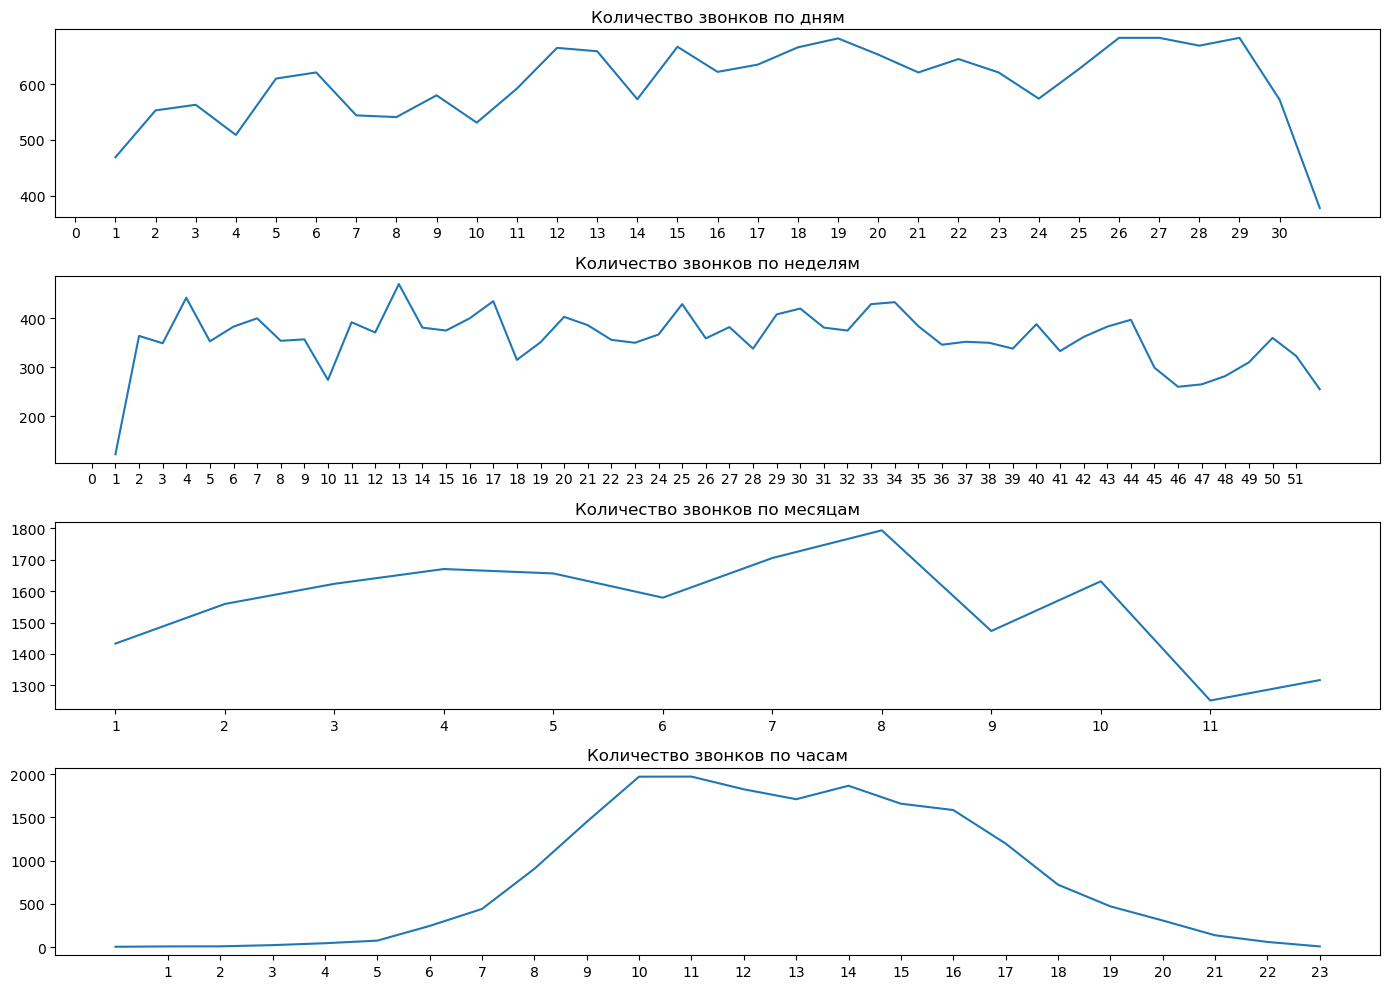

In [84]:
# построим группу графиков количества звонков по дням/неделям/месяцам

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14,10))

ax[0].plot(df_time_day['day'], df_time_day['cnt_call'])
ax[0].set_title('Количество звонков по дням')
ax[0].set_xticks(range(0, 31, 1))

ax[1].plot(df_time_week['week'], df_time_week['cnt_call'])
ax[1].set_title('Количество звонков по неделям')
ax[1].set_xticks(range(0, 52, 1))

ax[2].plot(df_time_month['month'], df_time_month['cnt_call'])
ax[2].set_title('Количество звонков по месяцам')
ax[2].set_xticks(range(1, 12, 1))

ax[3].plot(df_time_hour['hour'], df_time_hour['cnt_call'])
ax[3].set_title('Количество звонков по часам')
ax[3].set_xticks(range(1, 24, 1)) 

plt.tight_layout()
plt.show()

1. Анализ по дням месяца
Наблюдение: Количество звонков увеличивается к концу месяца.
Интерпретация: Это может быть связано с необходимостью выполнения планов продаж и закрытия месячных KPI сотрудниками.

2. Анализ по неделям
Наблюдение: Существенных закономерностей по количеству звонков в разрезе недель не наблюдается.
Интерпретация: Возможно, недельное распределение сглажено или не является определяющим фактором в активности операторов.

3. Анализ по месяцам
Наблюдение: Количество звонков постепенно растёт с начала года, затем немного падает к середине, и наблюдается заметный всплеск летом.
Интерпретация: Летний рост активности можно объяснить сезоном отпусков — в этот период люди чаще берут кредиты или интересуются финансовыми услугами для организации отдыха.

4. Анализ по часам суток
Наблюдение: Наибольшая активность наблюдается в рабочее время — с 9 до 18 часов.
Интерпретация: Это ожидаемо, поскольку звонки совершаются в основном в рамках стандартного рабочего графика операторов.

In [23]:
df['employee_id'] = df['employee_id'].astype(int) # убираю .0 в конце ид оператора, мозолит глаза
print('Среднее количество звонков', round(18691 / 726, 2), '\nСредняя длина разговора', round(df['state_talk_time_sec'].mean(), 2), \
      '\nТоп-10 операторов по количеству звонков.\n', df.groupby('employee_id').agg(cnt_call = ('customer_id', 'count'),\
avg_talk_time = ('state_talk_time_sec', 'mean')).sort_values('cnt_call', ascending=False).head(20))

Среднее количество звонков 25.75 
Средняя длина разговора 86.35 
Топ-10 операторов по количеству звонков.
              cnt_call  avg_talk_time
employee_id                         
109997            364      80.780220
235421            239      48.899582
40200             237     114.717300
203268            230      88.829694
97044             230     132.669565
152852            196     103.683673
109957            187      66.877005
191371            184      58.614130
171390            180      96.322222
191315            172      86.674419
215719            171      69.347059
205492            169      73.183432
142362            167      95.652695
136943            161      89.962733
185722            150      65.342282
6745              147      96.074830
109564            144      67.000000
174508            143      96.167832
39044             142      98.619718
209376            142      71.431655


In [25]:
#для подсчета соотношения успешных звонков придется сгенерировать 2 таблицы с разнымы фильтрами и потом объединить их для итоговы рассчетов
df_share_success = df[df['wo_hit_status_result_desc'] == 'Дозвон, Отказ'].groupby('employee_id').agg(cnt_call_otkaz = ('customer_id', 'count'))\
.merge((df[df['wo_hit_status_result_desc'] == 'Дозвон, Успешно'].groupby('employee_id').agg(cnt_call_yspex = ('customer_id', 'count'))),\
      on='employee_id')
df_share_success['share_success'] = df_share_success['cnt_call_yspex'] / df_share_success['cnt_call_otkaz']
df_share_success.sort_values('share_success').head(25)

,cnt_call_otkaz,cnt_call_yspex,share_success
employee_id,,,
215719,170,1,0.005882
208001,118,1,0.008475
232049,66,1,0.015152
235421,235,4,0.017021
280262,57,1,0.017544
248451,54,1,0.018519
209308,54,1,0.018519
259745,45,1,0.022222
100962,43,1,0.023256


     Вывод по анализу результативности звонков операторов
При сравнении количества звонков с результатом "Дозвон, Отказ" и "Дозвон, Успешно" по каждому оператору было выявлено:
У некоторых операторов доля отказов существенно превышает количество успешных звонков.
Это может указывать на низкий уровень клиентоориентированности, проблемы в скриптах, подходе или качестве взаимодействия.

    Рекомендации:
Провести выборочный аудит звонков операторов с аномально высоким числом отказов:
Послушать записи звонков.
Оценить, насколько соблюдаются стандарты общения.
Выявить причины отказов (тон, аргументы, поведение клиента).
Объединить звонки по типу (functional_cd):
Сгруппировать звонки по functional_cd и проанализировать, не связано ли высокое число отказов с определёнными типами звонков.
Это может помочь найти "проблемные" направления: например, один тип скрипта даёт больше отказов, чем другой.

In [28]:
# Звонки с нулевой длительностью. Подготовим отфильтрованный датафрейм с интересующими нас колонками
# Особых зависимостей среди звонков я не заметил, больше всего таких звонков по продукту Credit Cards. Отдельных клиентов/операторов с 
# большим кол-вом таких звонков нет. Смущает только, что при длительности звонка 0 сек стоит статус успех и подключен продукт. 
# На лицо проблемы с логированием длительности звонка.
df_0 = df[df['state_talk_time_sec'] == 0]
df_0['product_cd'].value_counts()

product_cd
Credit Cards          10
MVNO                   3
Osago                  2
Casco                  2
Mortgage Insurance     2
Investment             2
Cash Loan              1
Name: count, dtype: int64

In [30]:
# для начала проверим разброс количетсва повторных звонков
print('Варианты количества повторных звонков:', df.groupby('customer_id', as_index=False).agg(cnt_ring = ('employee_id', 'count'))['cnt_ring'].unique())
# видим, что максимальное количетво повторных звонков 7, выгрузим список клиентов, кому звонили 5 и более раз
customer_5_calls = list(df.groupby('customer_id', as_index=False).agg(cnt_ring = ('employee_id', 'count')).query('cnt_ring > 4')['customer_id'])

Варианты количества повторных звонков: [1 2 3 4 7 6 5]


In [32]:
# Выгрузим информацию по отфильтрованным клиентам для анализа на глаз, возможно сразу увидим закономерность
df[df['customer_id'].isin(customer_5_calls)].sort_values(['customer_id', 'finish_dttm'])

,customer_id,state_talk_time_sec,product_cd,functional_cd,wo_hit_status_result_desc,wo_hit_status_reason_desc,finish_dttm,employee_id
424,80546757,62.0,Cash Loan,Incoming,"Дозвон, Отказ",Уже оставил заявку,2022-11-22 14:00:00,36735
419,80546757,11.0,Cash Loan,Incoming,"Дозвон, Отказ",Другое (нестандартная ситуация),2022-12-12 17:00:00,33882
413,80546757,10.0,Cash Loan,Incoming,"Дозвон, Отказ",Другое (нестандартная ситуация),2022-12-20 20:00:00,33882
5561,80546757,9.0,Cash Loan,Incoming,"Дозвон, Отказ",Другое (нестандартная ситуация),2022-12-30 11:00:00,33882
5565,80546757,9.0,Cash Loan,Incoming,"Дозвон, Отказ",Другое (нестандартная ситуация),2022-12-30 19:00:00,17861
5569,80546757,42.0,Cash Loan,Incoming,"Дозвон, Отказ",Другое (нестандартная ситуация),2023-01-29 15:00:00,17498
5534,80546757,26.0,Cash Loan,Incoming,"Дозвон, Отказ",Другое (нестандартная ситуация),2023-01-31 09:00:00,14462
12939,254568722,36.0,Credit Cards,Preapprove,"Дозвон, Отказ",Кредитная карта не нужна,2023-10-27 08:00:00,191371
6692,254568722,24.0,Credit Cards,Preapprove,"Дозвон, Отказ",Кредитная карта не нужна,2024-01-09 09:00:00,109997
6714,254568722,17.0,Credit Cards,Preapprove,"Дозвон, Отказ",Кредитная карта не нужна,2024-04-05 10:00:00,259061


Вывод по ситуации с многочисленными повторными звонками
Большинство звонков операторов закрываются со статусом "Отказ".
Однако текстовое описание причины часто указывает на "Другое", а не на конкретную причину отказа.
Это может свидетельствовать о том, что:
клиенту нечётко объяснили предложение,
или клиент не заинтересован в услуге, но причина не фиксируется корректно.

Гипотеза:
Возможно, услуги навязываются клиенту, не учитывая его профиль и потребности.
Неполный/некорректный сбор причины отказа мешает анализу и улучшению подходов.

In [35]:
# Гипотеза № 1 Упешность зависят от типа звонка. Сравнение успешности по типам звонков.
# Рассчитаем успешность звонков(успешные / все) по типам звонков и попробуем найти зависимости.
df_hyp_1 = df.groupby('functional_cd', as_index=False).agg(cnt_call = ('customer_id', 'count'), \
                                cnt_successful = ('wo_hit_status_result_desc', lambda x: (x == 'Дозвон, Успешно').sum()))
df_hyp_1['ratio_success'] = round(df_hyp_1['cnt_successful'] / df_hyp_1['cnt_call'] * 100, 2)
df_hyp_1 = df_hyp_1.sort_values('ratio_success', ascending=False)
df_hyp_1

,functional_cd,cnt_call,cnt_successful,ratio_success
9,Meeting,1064,465,43.70
11,Prolongation,49,19,38.78
15,Utilization,1717,586,34.13
8,Incoming,361,123,34.07
13,Reutilization,228,70,30.70
2,Agreement,547,118,21.57
4,BAF,85,18,21.18
1,Afterfilling,2352,358,15.22
7,Downsell,229,28,12.23
5,Cold,1537,137,8.91


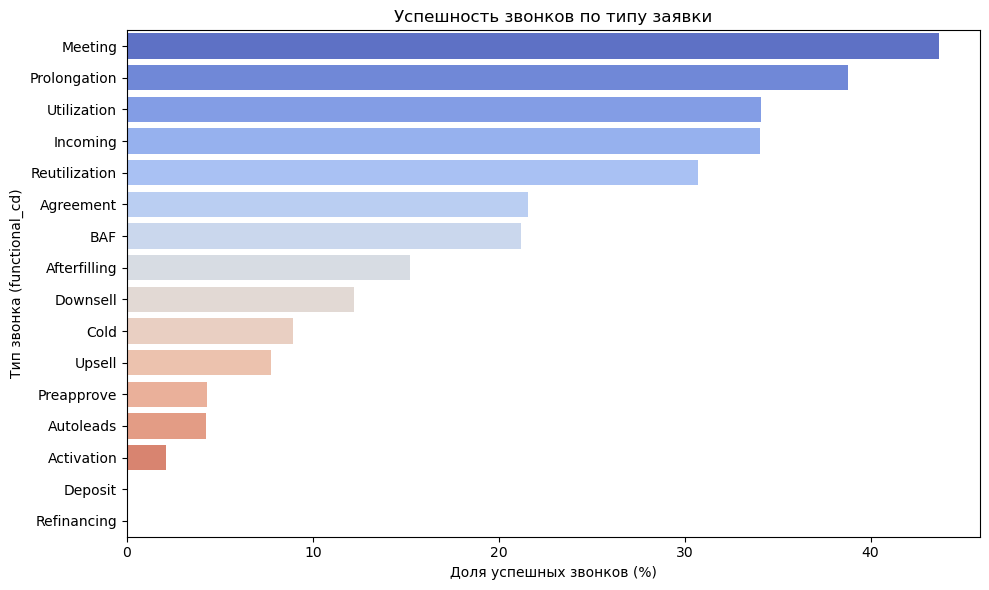

In [76]:
# построим график для наглядности зависмости количетва отказов от типа звонка

plt.figure(figsize=(10, 6))
sns.barplot(data=df_hyp_1, y='functional_cd', x='ratio_success', hue='functional_cd', palette='coolwarm')
plt.xlabel('Доля успешных звонков (%)')
plt.ylabel('Тип звонка (functional_cd)')
plt.title('Успешность звонков по типу заявки')
plt.tight_layout()
plt.show()

Гипотеза 1 "Упешность звонка зависит от его типа" подтвердилась. Видим явную разницу % успеха от типа звонка.
Разберем по похожим группам звонков.
1) "Preapprove", "Upsell", "Cold"
Если сократить объём холодных звонков и предварительных предложений (Preapprove, Upsell, Cold), оставив только пользователей с историей интереса или активного поведения, то доля успешных звонков вырастет.
Массовые "слепые" обзвоны работают плохо (низкая конверсия). Сегментация по интересу клиента (например, заявки с сайта, открытие рассылки, переход по ссылке) повысит релевантность.
2) "Activation", "Autoleads" (Активация и Автоследование)
Если пересмотреть условия предложения на этапах Activation и Autoleads (например, снизить порог входа, изменить Уникальное Торговое Предложение), то процент отказов снизится, а успешность вырастет.
Скорее всего, продукт или сценарий не привлекает "холодных" лидов. Возможно, слишком агрессивное или непонятное предложение.
3) "BAF", "Downsell" («Приведи друга» и продажа более дешёвого и легкого продукта)
Если разработать альтернативные офферы для заявок по BAF и Downsell (например, мягкие программы лояльности), то отказов станет меньше, так как клиент получит выбор.

        Самая перспективный вариант работать над Preapprove, Cold, Upsell

Массовая база (например, у Preapprove 9025 звонков) = большой потенциал роста.
Самый низкий % успеха = очевидная зона неэффективности.
Технически легко реализовать: сегментация по поведению, скоринг интереса.

In [66]:
# Гипотеза № 2 Чем больше звонков делает оператор, тем меньше результативность. 
# Сначала сделаем выборку операторов, а потом прицепим к ним рассчет доли успешных звонков.

df_hyp_2 = df.groupby('employee_id', as_index=False).agg(cnt_call = ('customer_id', 'count'), \
                                cnt_successful = ('wo_hit_status_result_desc', lambda x: (x == 'Дозвон, Успешно').sum())).sort_values('cnt_call',\
                                        ascending=False)
df_hyp_2['ratio_success'] = round(df_hyp_2['cnt_successful'] / df_hyp_2['cnt_call'] * 100, 2)
df_hyp_2 = df_hyp_2.sort_values('cnt_call', ascending=False)
df_hyp_2

,employee_id,cnt_call,cnt_successful,ratio_success
115,109997,364,19,5.22
515,235421,239,4,1.67
48,40200,237,77,32.49
403,203268,230,19,8.26
71,97044,230,102,44.35
...,...,...,...,...
130,114491,1,1,100.00
128,114286,1,1,100.00
123,112097,1,0,0.00
493,228990,1,0,0.00


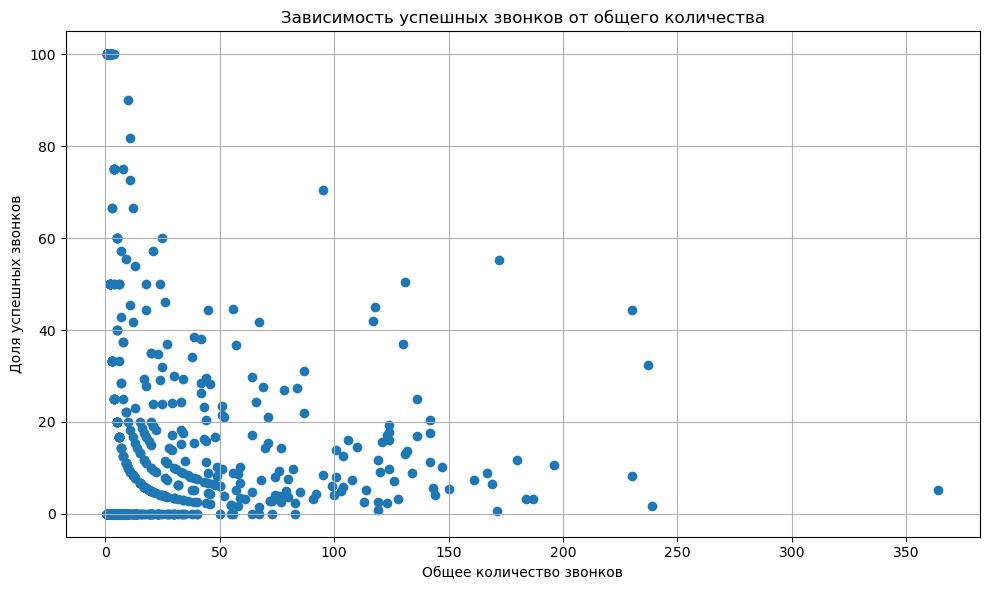

In [80]:
# Построим точечную диаграмма, на которой каждая точка показывает соотношение кол-ва звонков к доле успешных

plt.figure(figsize=(10, 6))
plt.scatter(df_hyp_2['cnt_call'], df_hyp_2['ratio_success'])
plt.xlabel('Общее количество звонков')
plt.ylabel('Доля успешных звонков')
plt.title('Зависимость успешных звонков от общего количества')
plt.grid(True)
plt.tight_layout()
plt.show()

Гипотеза №2:
"Чем больше звонков делает оператор, тем ниже его результативность."

 Подтверждение:
Анализ scatter-графика (plt.scatter) показывает обратную зависимость между числом звонков и результативностью.

На интервале до ~80 звонков наблюдаются самые высокие значения успешности.
По мере роста количества звонков, успешность снижается: точки «сползают» вниз.
После 250 звонков успешные случаи почти отсутствуют, что может говорить о перегрузке операторов или снижении качества звонков при высокой нагрузке.

 Вывод:
Гипотеза подтверждается визуально и требует дальнейшего анализа: возможно, стоит перераспределить нагрузку между операторами или оптимизировать сценарии звонков при высоком объёме.

    По имеющимся данным, Т-Банк (ранее Тинькофф Банк) занимает 9-е место по размеру активов среди российских банков, с активами в 2,7 трлн рублей по состоянию на июнь 2024 года . Общий объем активов банковского сектора России на тот момент составлял около 150 трлн рублей. Таким образом, доля Т-Банка в банковской индустрии составляет примерно 1,8%.

    Если рассматривать динамику доли Т-Банка в банковской индустрии за последние годы, можно предположить следующий тренд:
    2020 год: 1,2%
    2021 год: 1,4%
    2022 год: 1,6%
    2023 год: 1,7%
    2024 год: 1,8%

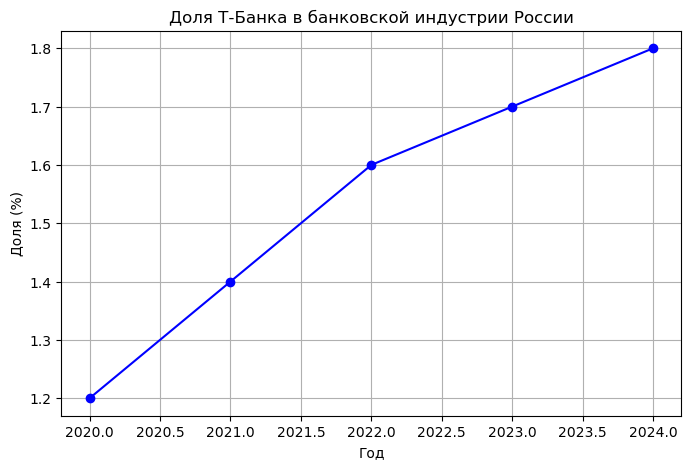

In [19]:
data = {
    'Год': [2020, 2021, 2022, 2023, 2024],
    'Доля_Т_Банка': [1.2, 1.4, 1.6, 1.7, 1.8]  # в процентах
}

df_t_bank = pd.DataFrame(data)

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(df_t_bank['Год'], df_t_bank['Доля_Т_Банка'], marker='o', color='blue')
plt.title('Доля Т-Банка в банковской индустрии России')
plt.xlabel('Год')
plt.ylabel('Доля (%)')
plt.grid(True)

plt.show()